In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pickle, gpflow, os.path, os
import tensorflow as tf
import math
from sklearn.model_selection import train_test_split
from tqdm.notebook import trange
from graph_matern.kernels.graph_matern_kernel import GraphMaternKernel
from graph_matern.inducing_variables import GPInducingVariables
from graph_matern.svgp import GraphSVGP
from scipy import sparse
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier

from graph_gaussian_process.graph_gaussian_process_model_classification import GraphGPC

dtype=tf.float64

gpflow.config.set_default_float(dtype)
gpflow.config.set_default_summary_fmt("notebook")
tf.get_logger().setLevel('ERROR')

In [2]:
def plot_mnist():
    fig = plt.figure(figsize = (15,5))
    ax = fig.add_subplot(131)
    ax.imshow(X_train[0],cmap='gray')
    ax.set_title('Label: '+ str(y_train[0]),fontsize=30)
    ax = fig.add_subplot(132)
    ax.imshow(X_train[1],cmap='gray')
    ax.set_title('Label: '+ str(y_train[1]),fontsize=30)
    ax = fig.add_subplot(133)
    ax.imshow(X_train[2],cmap='gray')
    ax.set_title('Label: '+ str(y_train[2]),fontsize=30)

# Three flat curves

In [10]:
# MAKE DATASET
xs = np.random.uniform(-10,10,500)
ys = []
for p in xs:
    ys.append(p**2 - 20 + np.random.normal()*abs(p))

xs_ = np.random.uniform(-10,10,500)
ys_ = []
for p in xs_:
    ys_.append(-p**2 + 20 + np.random.normal()*abs(p))

xs_3 = np.random.uniform(-7,7,500)
ys_3 = []
for p in xs_3:
    ys_3.append(p**3 - 30*p + 3*np.random.normal()*abs(p))

part1 = np.vstack((xs,ys,np.zeros(len(xs)))).T
part2 = np.vstack((xs_,ys_,np.ones(len(xs_)))).T
part3 = np.vstack((xs_3,ys_3,1+np.ones(len(xs_)))).T
data = np.vstack((part1,part2,part3))

np.random.shuffle(data)

scaler = MinMaxScaler()
scaler.fit(data[:,:2])
data_scaled = scaler.transform(data[:,:2])

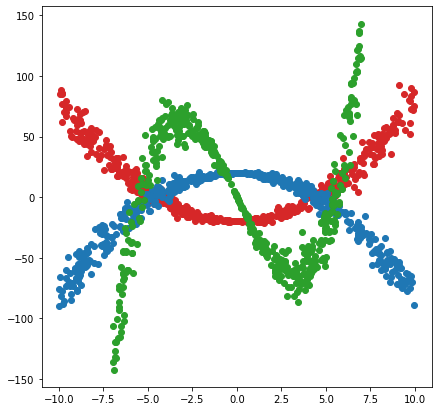

In [11]:
fig = plt.figure(figsize = (7,7))
ax = fig.add_subplot(111)
ax.scatter(xs, ys,c='tab:red')
ax.scatter(xs_, ys_,c='tab:blue')
ax.scatter(xs_3, ys_3,c='tab:green')

In [12]:
train_size = 750
train_ind = np.random.choice(len(data_scaled), train_size, replace=False)

ys=data[:,-1]

In [13]:
model = GraphGPC(k_neig=10,
                epsilon=0.1,
                num_eigenpairs=1500)

mean, var = model.fit_and_predict(data_scaled,train_ind,ys[train_ind], cls_number=3)

Number of features is greater than number of vertices. Number of features will be reduced.


  0%|          | 0/1000 [00:00<?, ?it/s]

In [15]:
test_ind = np.array(list(set(np.arange(len(data_scaled)))-set(train_ind)))
accuracy = np.count_nonzero((mean - ys[test_ind]) == 0) / len(test_ind)
print('Accuracy is {}'.format(accuracy))

Accuracy is 0.936


# MNIST

In [16]:
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

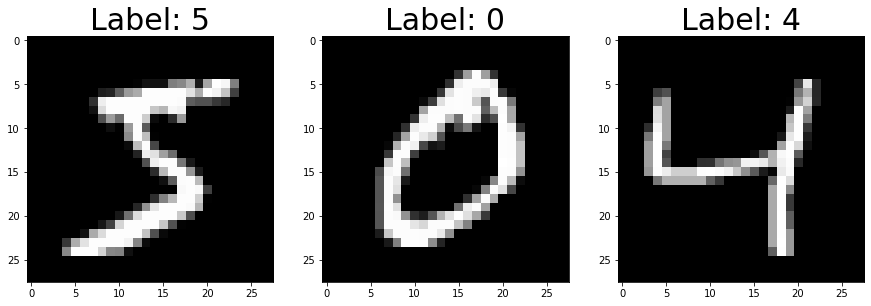

In [17]:
plot_mnist()

In [18]:
from skimage.transform import resize

X_resized = []
for img in X_train[:5000]:
    img = resize(img, (8,8))
    X_resized.append(img.ravel())
X_resized=np.array(X_resized)

y_resized = y_train

In [19]:
train_size = 1000
train_ind = np.random.choice(len(X_resized), train_size, replace=False)

In [20]:
model = GraphGPC(k_neig=30,
                epsilon=0.3,
                num_eigenpairs=5000)

mean, var = model.fit_and_predict(X_resized,train_ind,y_resized[train_ind], cls_number=10)

Number of features is greater than number of vertices. Number of features will be reduced.


  0%|          | 0/1000 [00:00<?, ?it/s]

In [22]:
test_ind = np.array(list(set(np.arange(len(X_resized)))-set(train_ind)))
accuracy = np.count_nonzero((mean - y_resized[test_ind]) == 0) / len(test_ind)
print('Accuracy is {}'.format(accuracy))

Accuracy is 0.93225
